In [ ]:
# Basic PINN for ISF membrane stress equilibrium with training loop

import torch
import torch.nn as nn
import torch.autograd as autograd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")



✅ Using device: cpu


In [ ]:
# Load thickness profile
df_thick = pd.read_csv('thickness_profile.csv')
print(df_thick.head())

z_data = torch.tensor(df_thick['Depth'].values, dtype=torch.float32).view(-1,1).to(device)
t_data = torch.tensor(df_thick['Thickness'].values, dtype=torch.float32).view(-1,1).to(device)
print(f"Loaded {len(z_data)} points.")


   Depth  Thickness
0      0        2.0
1      1        1.9
2      2        1.8
3      3        1.7
4      4        1.5
Loaded 21 points.


In [ ]:
# PINN architecture
class StressPINN(nn.Module):
    def __init__(self, layers):
        super(StressPINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 2):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            self.layers.append(nn.Tanh())
        self.out = nn.Linear(layers[-2], layers[-1])

    def forward(self, z):
        x = z
        for layer in self.layers:
            x = layer(x)
        out = self.out(x)
        sigma_t = out[:, 0:1]
        sigma_phi = out[:, 1:2]
        sigma_theta = out[:, 2:3]
        return sigma_t, sigma_phi, sigma_theta


In [ ]:
# Constants
alpha = torch.tensor(np.radians(70)).to(device)
mu = 0.1
mu_phi = 0.92 * mu
mu_theta = 0.08 * mu
r1 = torch.tensor(6.0).to(device)
sin_alpha = torch.sin(alpha)
cos_alpha = torch.cos(alpha) + 1e-8
sigma_yield = 200.0

In [ ]:
# Residuals
def membrane_residuals(model, z, t_data):
    z.requires_grad_(True)
    sigma_t, sigma_phi, sigma_theta = model(z)
    t = t_data

    # Radial coordinate
    r = z / sin_alpha

    # Circumferential radius
    r2 = r1 + r

    # R1
    R1 = sigma_t / t + sigma_phi / r1 + sigma_theta / r2

    dsigma_phi_dz = autograd.grad(sigma_phi, z, grad_outputs=torch.ones_like(sigma_phi), create_graph=True, allow_unused=True)[0]
    dsigma_t_dz = autograd.grad(sigma_t, z, grad_outputs=torch.ones_like(sigma_t), create_graph=True, allow_unused=True)[0]

    dsigma_phi_dr = dsigma_phi_dz / sin_alpha
    dsigma_t_dr = dsigma_t_dz / sin_alpha

    R2 = dsigma_phi_dr + (sigma_phi - sigma_theta)/r + mu_phi * sigma_t/(t * sin_alpha) + (sigma_phi/t) * dsigma_t_dr

    dsigma_theta_dz = autograd.grad(sigma_theta, z, grad_outputs=torch.ones_like(sigma_theta), create_graph=True, allow_unused=True)[0]
    R3 = dsigma_theta_dz / sin_alpha + mu_theta * sigma_t

    sigma_vm = torch.sqrt(sigma_phi**2 + sigma_theta**2 - sigma_phi * sigma_theta)
    R_yield = torch.clamp(sigma_yield - sigma_vm, min=0.0)

    return R1, R2, R3, R_yield, sigma_t, sigma_phi, sigma_theta




In [ ]:
# Loss
def pinn_loss(model, z_data, t_data):
    R1, R2, R3, R_yield, sigma_t, sigma_phi, sigma_theta = membrane_residuals(model, z_data, t_data)
    loss_eq = torch.mean(R1**2) + torch.mean(R2**2) + torch.mean(R3**2)
    loss_yield = torch.mean(R_yield**2)
    sigma_theta0 = model(torch.tensor([[0.0]]).to(device))[2]
    loss_bc = torch.mean(sigma_theta0**2)
    return loss_eq + loss_yield + loss_bc


In [ ]:
# Training loop
model = StressPINN([1, 20, 20, 3]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, z_data, t_data)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6e}")

Epoch 0: Loss = inf
Epoch 500: Loss = nan
Epoch 1000: Loss = nan
Epoch 1500: Loss = nan
Epoch 2000: Loss = nan
Epoch 2500: Loss = nan
Epoch 3000: Loss = nan
Epoch 3500: Loss = nan
Epoch 4000: Loss = nan
Epoch 4500: Loss = nan


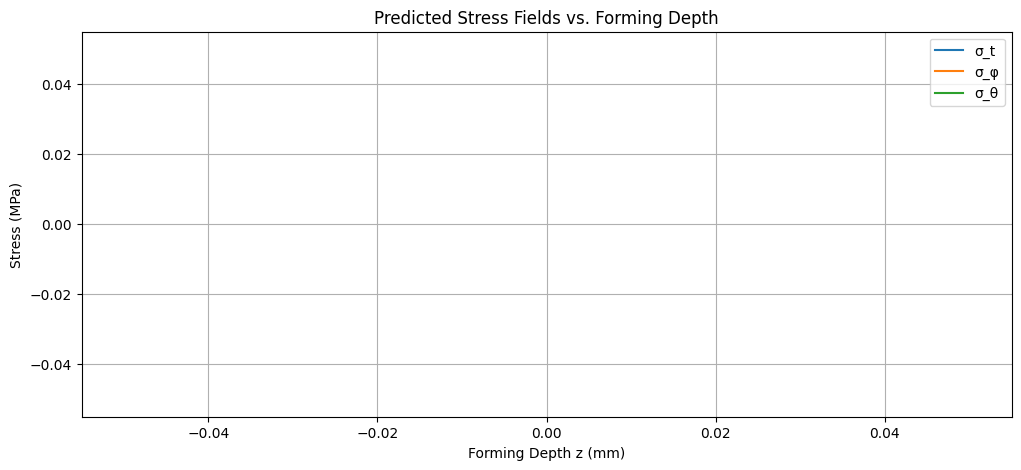

In [ ]:
sigma_t, sigma_phi, sigma_theta = model(z_data)

plt.figure(figsize=(12, 5))
plt.plot(z_data.cpu().detach().numpy(), sigma_t.cpu().detach().numpy(), label="σ_t")
plt.plot(z_data.cpu().detach().numpy(), sigma_phi.cpu().detach().numpy(), label="σ_φ")
plt.plot(z_data.cpu().detach().numpy(), sigma_theta.cpu().detach().numpy(), label="σ_θ")
plt.xlabel("Forming Depth z (mm)")
plt.ylabel("Stress (MPa)")
plt.title("Predicted Stress Fields vs. Forming Depth")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm  # color maps
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D


In [ ]:
# Evaluate on a smooth grid
z_vals = torch.linspace(z_data.min(), z_data.max(), 200).view(-1,1).to(device)
sigma_t_vals, sigma_phi_vals, sigma_theta_vals = model(z_vals)

# Convert to numpy
z_np = z_vals.cpu().detach().numpy().flatten()
sigma_t_np = sigma_t_vals.cpu().detach().numpy().flatten()
sigma_phi_np = sigma_phi_vals.cpu().detach().numpy().flatten()
sigma_theta_np = sigma_theta_vals.cpu().detach().numpy().flatten()


In [ ]:
# Wall angle (deg)
alpha_deg = 50
alpha_rad = np.radians(alpha_deg)

# Define base radius
r_base = 35  # mm,

# Radius along depth
r_np = r_base - z_np * np.tan(alpha_rad)

# Azimuthal mesh
phi = np.linspace(0, 2*np.pi, 100)
Z, PHI = np.meshgrid(z_np, phi)
R, _ = np.meshgrid(r_np, phi)

# Convert to cartesian
X = R * np.cos(PHI)
Y = R * np.sin(PHI)
Z = Z


In [ ]:
# Expand stress to 2D for plotting
sigma_t_grid = np.tile(sigma_t_np, (len(phi), 1))
sigma_phi_grid = np.tile(sigma_phi_np, (len(phi), 1))
sigma_theta_grid = np.tile(sigma_theta_np, (len(phi), 1))


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

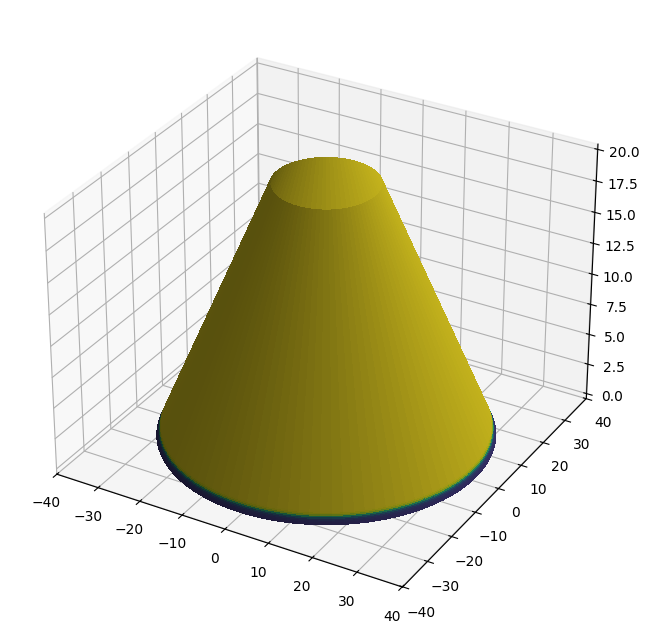

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, facecolors=cm.viridis(sigma_t_grid / np.max(sigma_t_grid)),
                       rstride=1, cstride=1, linewidth=0, antialiased=False)
m = cm.ScalarMappable(cmap=cm.viridis)
m.set_array(sigma_t_np)
fig.colorbar(m, shrink=0.5, aspect=5, label='σ_t (MPa)')

ax.set_title('3D Cone - Through-thickness Stress (σ_t)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
plt.show()


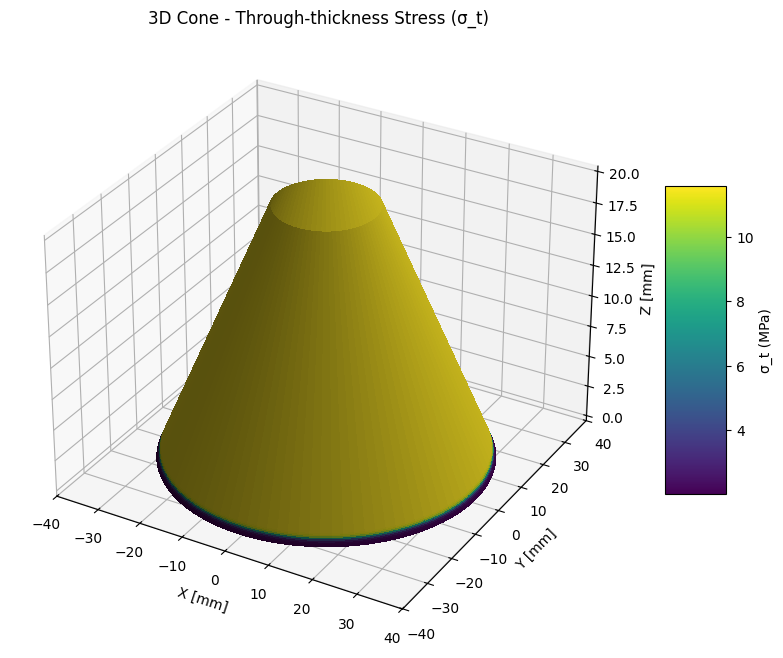

In [ ]:
import matplotlib as mpl

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Normalize colors to data range
norm = mpl.colors.Normalize(vmin=np.min(sigma_t_np), vmax=np.max(sigma_t_np))
facecolors = cm.viridis(norm(sigma_t_grid))

surf = ax.plot_surface(X, Y, Z, facecolors=facecolors,
                       rstride=1, cstride=1, linewidth=0, antialiased=False)

# Proper ScalarMappable for colorbar
m = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
m.set_array(sigma_t_np)

# Explicitly attach colorbar to this Axes
fig.colorbar(m, ax=ax, shrink=0.5, aspect=5, label='σ_t (MPa)')

ax.set_title('3D Cone - Through-thickness Stress (σ_t)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
plt.show()


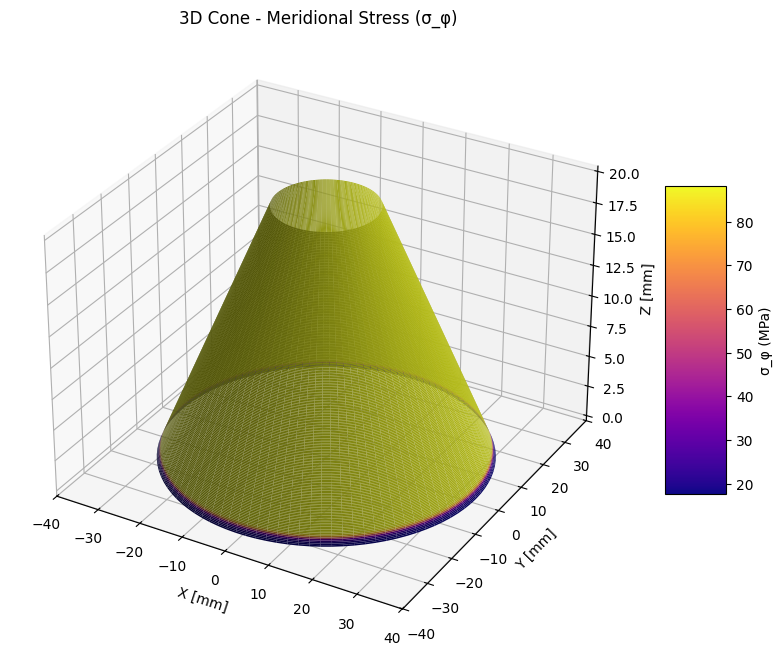

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

norm = mpl.colors.Normalize(vmin=np.min(sigma_phi_np), vmax=np.max(sigma_phi_np))
facecolors = cm.plasma(norm(sigma_phi_grid))

surf = ax.plot_surface(X, Y, Z, facecolors=facecolors, rstride=1, cstride=1, linewidth=0)

m = cm.ScalarMappable(norm=norm, cmap=cm.plasma)
m.set_array(sigma_phi_np)

fig.colorbar(m, ax=ax, shrink=0.5, aspect=5, label='σ_φ (MPa)')

ax.set_title('3D Cone - Meridional Stress (σ_φ)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
plt.show()


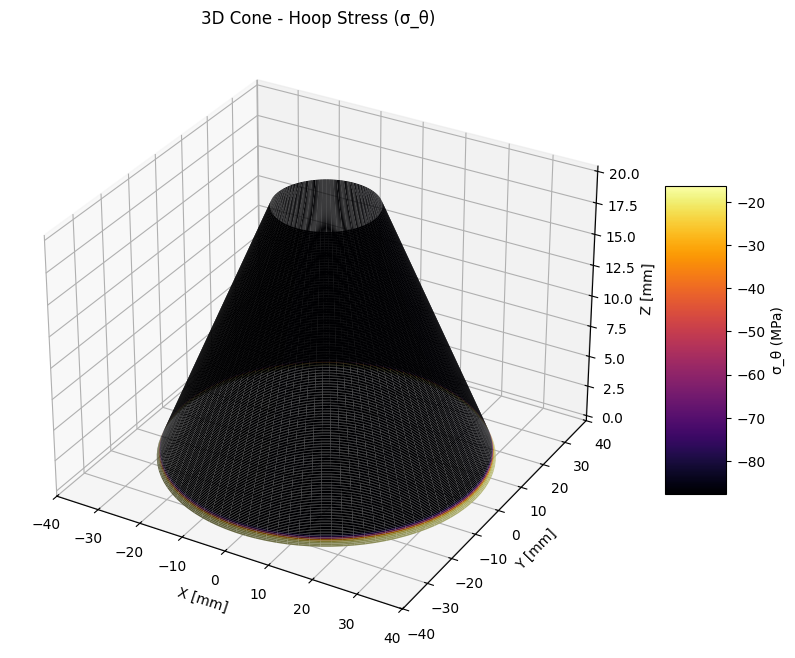

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

norm = mpl.colors.Normalize(vmin=np.min(sigma_theta_np), vmax=np.max(sigma_theta_np))
facecolors = cm.inferno(norm(sigma_theta_grid))

surf = ax.plot_surface(X, Y, Z, facecolors=facecolors, rstride=1, cstride=1, linewidth=0)

m = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
m.set_array(sigma_theta_np)

fig.colorbar(m, ax=ax, shrink=0.5, aspect=5, label='σ_θ (MPa)')

ax.set_title('3D Cone - Hoop Stress (σ_θ)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# Geometric params
R_upper = 37.5   # mm
R_lower = 15.0   # mm
alpha_deg = 60   # degrees
alpha_rad = np.radians(alpha_deg)

# Forming depth
Z_max = (R_upper - R_lower) / np.tan(alpha_rad)
print(f"Forming depth Z = {Z_max:.2f} mm")

# z range
z_np = np.linspace(0, Z_max, 200)


Forming depth Z = 12.99 mm


In [ ]:
R_np = R_upper - z_np * np.tan(alpha_rad)


In [ ]:
import torch

# If needed:
z_vals = torch.tensor(z_np, dtype=torch.float32).view(-1,1).to(device)
sigma_t_vals, sigma_phi_vals, sigma_theta_vals = model(z_vals)

sigma_t_np = sigma_t_vals.cpu().detach().numpy().flatten()
sigma_phi_np = sigma_phi_vals.cpu().detach().numpy().flatten()
sigma_theta_np = sigma_theta_vals.cpu().detach().numpy().flatten()


In [ ]:
phi = np.linspace(0, 2*np.pi, 100)
Z, PHI = np.meshgrid(z_np, phi)
R, _ = np.meshgrid(R_np, phi)

X = R * np.cos(PHI)
Y = R * np.sin(PHI)


In [ ]:
sigma_t_grid = np.tile(sigma_t_np, (len(phi), 1))
sigma_phi_grid = np.tile(sigma_phi_np, (len(phi), 1))
sigma_theta_grid = np.tile(sigma_theta_np, (len(phi), 1))


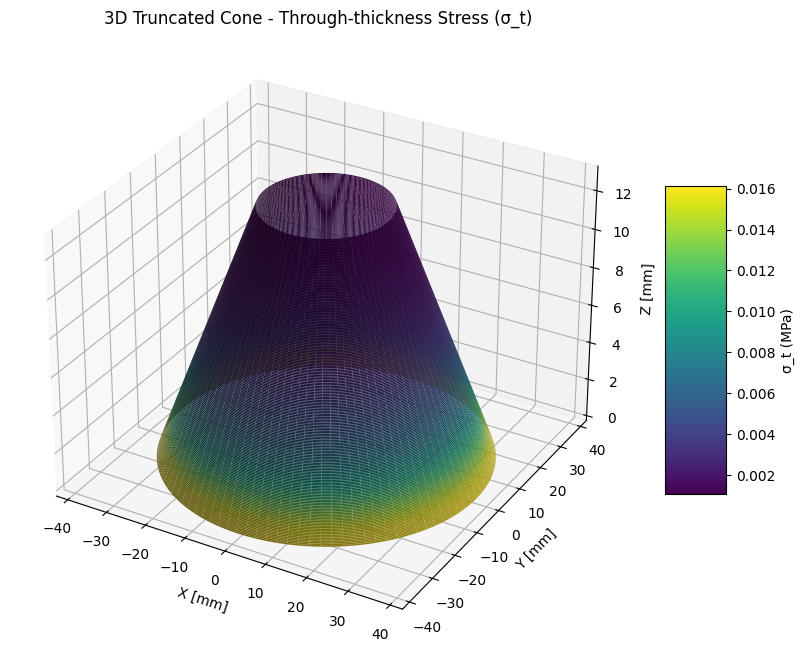

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

norm = mpl.colors.Normalize(vmin=np.min(sigma_t_np), vmax=np.max(sigma_t_np))
facecolors = cm.viridis(norm(sigma_t_grid))

surf = ax.plot_surface(X, Y, Z, facecolors=facecolors, rstride=1, cstride=1, linewidth=0)
m = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
m.set_array(sigma_t_np)

fig.colorbar(m, ax=ax, shrink=0.5, aspect=5, label='σ_t (MPa)')

ax.set_title('3D Truncated Cone - Through-thickness Stress (σ_t)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
plt.show()


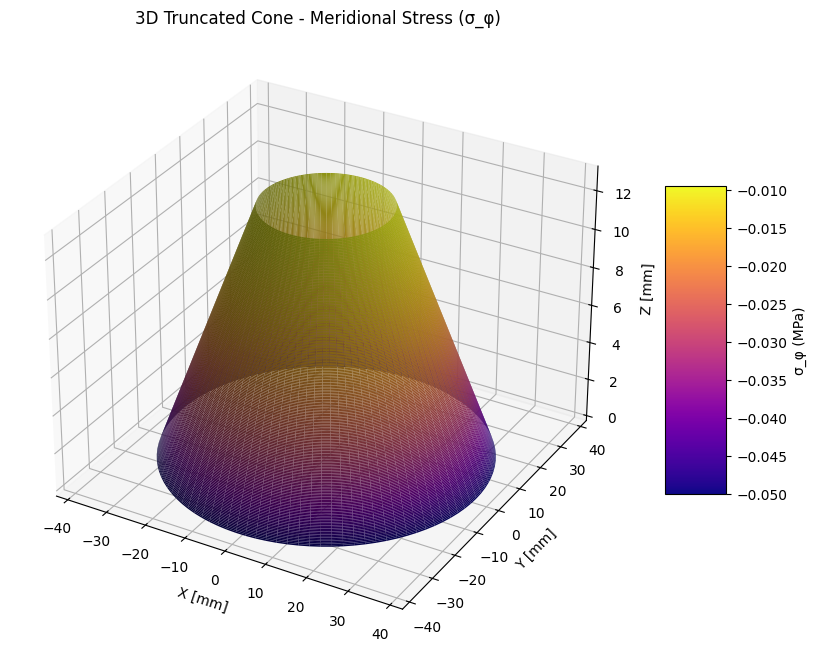

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

norm = mpl.colors.Normalize(vmin=np.min(sigma_phi_np), vmax=np.max(sigma_phi_np))
facecolors = cm.plasma(norm(sigma_phi_grid))

surf = ax.plot_surface(X, Y, Z, facecolors=facecolors, rstride=1, cstride=1, linewidth=0)
m = cm.ScalarMappable(norm=norm, cmap=cm.plasma)
m.set_array(sigma_phi_np)

fig.colorbar(m, ax=ax, shrink=0.5, aspect=5, label='σ_φ (MPa)')

ax.set_title('3D Truncated Cone - Meridional Stress (σ_φ)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
plt.show()


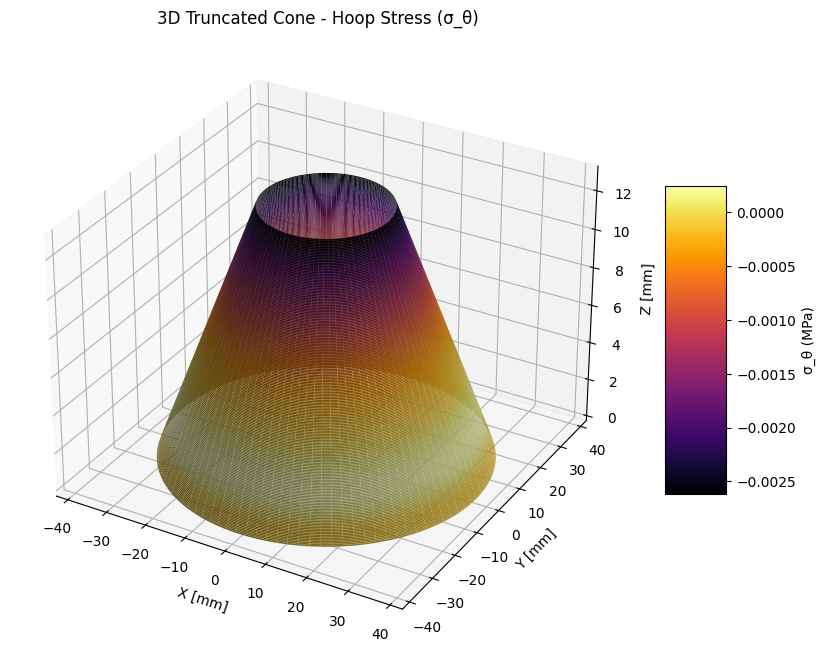

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

norm = mpl.colors.Normalize(vmin=np.min(sigma_theta_np), vmax=np.max(sigma_theta_np))
facecolors = cm.inferno(norm(sigma_theta_grid))

surf = ax.plot_surface(X, Y, Z, facecolors=facecolors, rstride=1, cstride=1, linewidth=0)
m = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
m.set_array(sigma_theta_np)

fig.colorbar(m, ax=ax, shrink=0.5, aspect=5, label='σ_θ (MPa)')

ax.set_title('3D Truncated Cone - Hoop Stress (σ_θ)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
plt.show()
